# Q1
Generate your own random numbers in range [0,1] using multiplicative linear congruential generator defined by:
<!-- xn = (a xn−1) mod m -->
$$ x_n = (a x_{n-1}) \mod m $$

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm, trange

In [2]:
class Random:
    def __init__(self, seed: float = None, range: list = [0, 1]):
        if seed is None:
            import time 
            seed = int((time.time() * 1e4) % 10) / 10
            print(f"Seed not provided, using {seed = }.")
        self.seed = seed
        self.scale = lambda x: range[0] + x*(range[1]-range[0])

    def uniform(self, a, m):
        self.seed = (a*self.seed) % m
        return self.scale(self.seed / m)

using a = 65, m = 1021

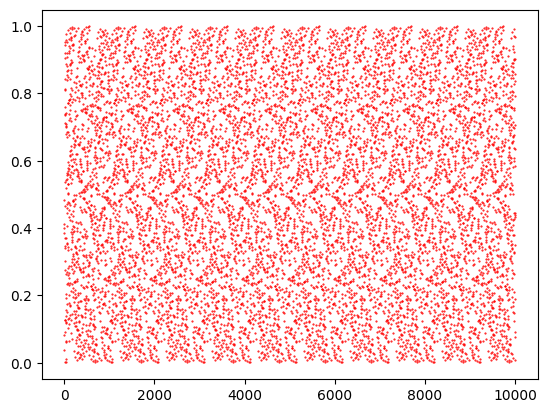

In [3]:
r1 = Random(seed=22, range=[0, 1])
N = int(1e4)
x1 = [r1.uniform(a=65, m=1021) for _ in range(N)]
plt.plot(x1, "r.", markersize=1)

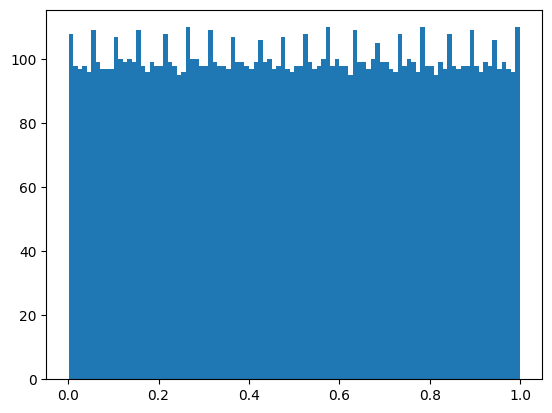

In [4]:
a = plt.hist(x1, bins=100)

using a = 572, m = 16381

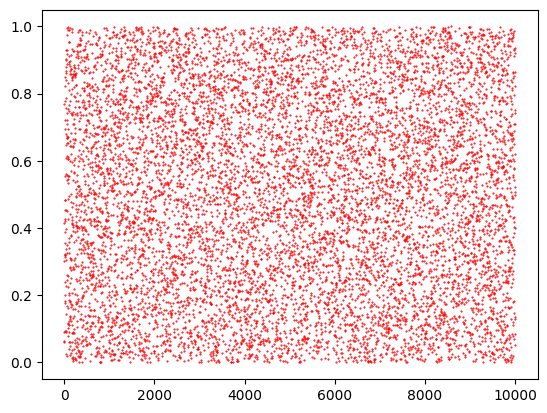

In [5]:
r2 = Random(seed=22, range=[0, 1])
N = int(1e4)
x2 = [r2.uniform(a=572, m=16381) for _ in range(N)]
plt.plot(x2, "r.", markersize=1)

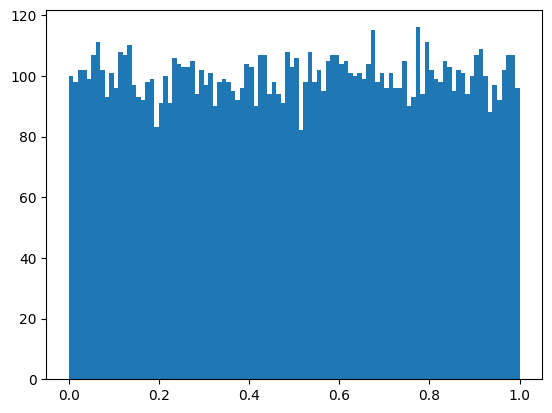

In [6]:
a = plt.hist(x2, bins=100)

Here we can clearly see that a=572,m=16381 is better choice than a=65,m=1021 from the generated graphs.

# Q2
Use Monte Carlo and pRNG of Problem 1 to approximate the integral $ \int_{-\pi/2}^{\pi/2} \cos{x} dx $. Consider $N \in [1000, 100000]$ in steps of 1000 and plot the convergence.

In [7]:
import random
def monte_carlo_integrate(f, N, ll, ul, a, m, seed=22):
    r = Random(seed=seed, range=[ll, ul])
    s = 0
    for _ in range(N):
        s += f(r.uniform(a=a, m=m))
    return s / N * (ul - ll)

100%|██████████| 99/99 [00:08<00:00, 11.32it/s]


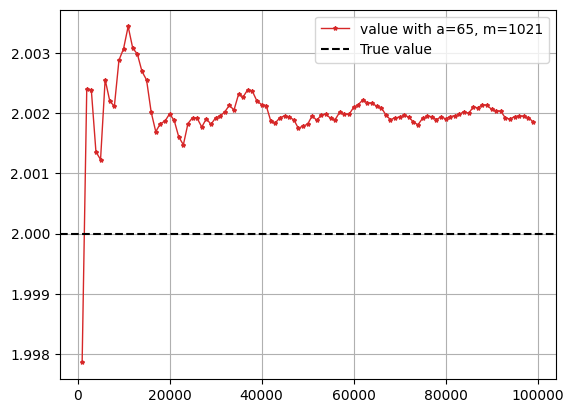

In [8]:
tests = np.arange(1e3, 1e5, 1e3, dtype=int)
values = np.zeros(len(tests))  # empty array to store the results

func = lambda x: np.cos(x)
for i, N in enumerate(tqdm(tests)):
    values[i] = monte_carlo_integrate(
        func,
        N,
        ll = -np.pi/2,
        ul = np.pi/2,
        a = 65,
        m = 1021
    )

plt.plot(tests, values, color="tab:red", marker="*", markersize=3, linewidth=1, label="value with a=65, m=1021")
plt.grid()
plt.axhline(y=2, color="k", linestyle="--", label="True value")
plt.legend()

100%|██████████| 99/99 [00:08<00:00, 11.27it/s]


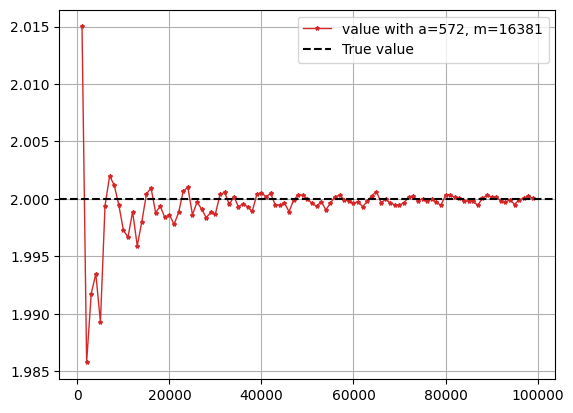

In [9]:
tests = np.arange(1e3, 1e5, 1e3, dtype=int)
values = np.zeros(len(tests))  # empty array to store the results

func = lambda x: np.cos(x)
for i, N in enumerate(tqdm(tests)):
    values[i] = monte_carlo_integrate(
        f  = func,
        N  = N,
        ll = -np.pi/2,
        ul = np.pi/2,
        a  = 572,
        m  = 16381
    )

plt.plot(tests, values, color="tab:red", marker="*", markersize=3, linewidth=1, label="value with a=572, m=16381")
plt.grid()
plt.axhline(y=2, color="k", linestyle="--", label="True value")
plt.legend()

Here we can see that for a=65,m=1021 the convergence is not good as compared to a=572,m=16381.

In the first case, the result converges to 2.002 rather than 2.0. In the second case, the result converges to 2.0. In the first case, the result is wrong not because there is something wrong in the code, but because the random numbers generated are not good enough.

As a result we would use a=572, m=16381 for the rest of the problems.

# Q3

Generate pseudo random numbers distributed as $\exp(−2x)$ for $0 \leq x \leq 3$ using inverse transform method and accept / reject method using sampling distribution $q(x) = 1 − x$, $0 \leq x \leq 1$. Histogram the sampled RNG in both case (generate at least 2000 RNs for the purpose).

## Inverse Transform Method

In [10]:
class RandomDist(Random):
    def __init__(self, seed: float = None, f_inv: callable = lambda x: x, range=[0, 3]):
        super().__init__(seed)
        self.transform = f_inv
        self.range = range
    def invTransform(self, a=572, m=16381):
        while True:
            u = self.transform(self.uniform(a=a, m=m))
            if u >= self.range[0] and u <= self.range[1]:
                return u

In [11]:
from library.integration import midpoint_rule  # just for plotting

100%|██████████| 100000/100000 [00:00<00:00, 284883.01it/s]


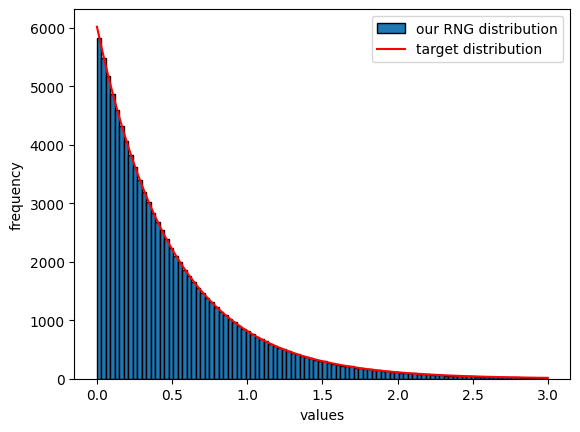

In [12]:
N = int(1e5)
bins = 100
till = 3
r = RandomDist(seed=22, f_inv=lambda u: -np.log(u)/2, range=[0, till])
distribution = [r.invTransform(a=572, m=16381) for _ in trange(N)]

# plot the histogram
plt.hist(distribution, bins=bins, color="tab:blue", edgecolor="k", label="our RNG distribution")
plt.xlabel("values")
plt.ylabel("frequency")

# plot the true distribution
x = np.linspace(0, till, 100)
f = lambda x: np.exp(-2*x)
# normalize the true distribution to the histogram
norm = N * midpoint_rule(f, 0, till/bins) / midpoint_rule(f, 0, till)
f_x = f(x-till/(bins*2)) * norm
plt.plot(x, f_x, "r", label="target distribution")

plt.legend()

## Accept / Reject Method

In [13]:
def generate_accept_reject_rng(f, g, r, ru, limits=[0, 3], a=572, m=16381):
    """Generate a random number using the accept-reject method.

    Args:
        f (callable): The distribution function.
        g (callable): The **scaled** model distribution function.
        r (Random): The random number generator. Which returns a random number from the model distribution (g).
        ru (Random): The random number generator. Which returns a random number from the uniform distribution.
        # m (int|float, optional): The scaling factor for the model distribution. Defaults to 1.
        limits (list, optional): The limits of the distribution. Defaults to [0, 3].
        a, m (int, optional): Parameters for the random number generator. Defaults to 572, 16381.

    Returns:
        float: A random number from the provided distribution function f.
    """
    rejections = 0
    while True:
        u = r.invTransform(a=a, m=m)
        p = ru.uniform(a=a, m=m)
        if p < f(u) / g(u):
            return u, rejections
        rejections += 1

100%|██████████| 100000/100000 [00:01<00:00, 86224.20it/s]


Acceptance rate: 57.61%


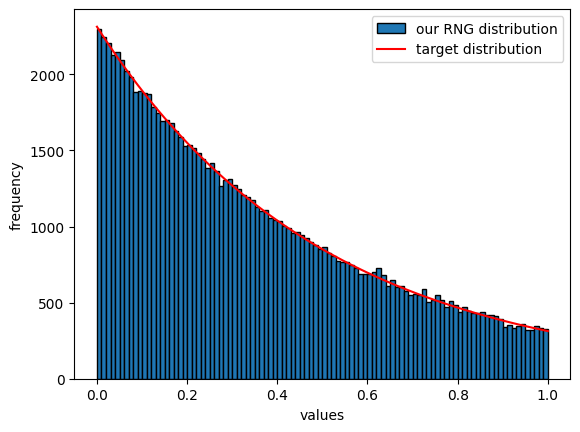

In [14]:
N = int(1e5)
bins = 100
till = 1

m = 0.5
f = lambda x: np.exp(-2*x)
q = lambda x: m*(2-x)
q_inv = lambda x: 2 - np.sqrt(4-2*x/m)  # inverse of cum(q)
r = RandomDist(seed=22, f_inv=q_inv, range=[0, till])
ru = Random(seed=22, range=[0, 1])

distribution = []
rejections = 0

for _ in trange(N):
    u, rej = generate_accept_reject_rng(f=f, g=q, r=r, ru=ru, limits=[0, till])
    distribution.append(u)
    rejections += rej

# plot the histogram
plt.hist(distribution, bins=bins, color="tab:blue", edgecolor="k", label="our RNG distribution")
plt.xlabel("values")
plt.ylabel("frequency")

# plot the true distribution
x = np.linspace(0, till, 100)
# normalize the true distribution to the histogram
norm = N * midpoint_rule(f, 0, till/bins) / midpoint_rule(f, 0, till)
f_x = f(x-till/(bins*2)) * norm
plt.plot(x, f_x, "r", label="target distribution")

plt.legend()

print(f"Acceptance rate: {N/(rejections+N):.2%}")

This was all that was asked in the Q3. Now, just for fun, let's do the same thing for the distribution $f(x) = e^{-5x}$, $0 \leq x \leq 1$.

100%|██████████| 100000/100000 [00:02<00:00, 44028.70it/s]


Acceptance rate: 26.30%


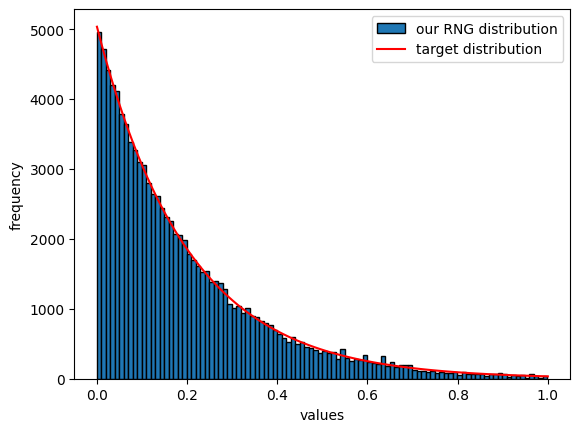

In [15]:
N = int(1e5)
bins = 100
till = 1

m = 0.5
f = lambda x: np.exp(-5*x)
q = lambda x: m*(2-x)
q_inv = lambda x: 2 - np.sqrt(4-2*x/m)  # inverse of cum(q)
r = RandomDist(seed=22, f_inv=q_inv, range=[0, till])
ru = Random(seed=22, range=[0, 1])

distribution = []
rejections = 0

for _ in trange(N):
    u, rej = generate_accept_reject_rng(f=f, g=q, r=r, ru=ru, limits=[0, till])
    distribution.append(u)
    rejections += rej

# plot the histogram
plt.hist(distribution, bins=bins, color="tab:blue", edgecolor="k", label="our RNG distribution")
plt.xlabel("values")
plt.ylabel("frequency")

# plot the true distribution
x = np.linspace(0, till, 100)
# normalize the true distribution to the histogram
norm = N * midpoint_rule(f, 0, till/bins) / midpoint_rule(f, 0, till)
f_x = f(x-till/(bins*2)) * norm
plt.plot(x, f_x, "r", label="target distribution")

plt.legend()

print(f"Acceptance rate: {N/(rejections+N):.2%}")

# Q4

Use Monte Carlo to evaluate the integral (taking $N = 10,000$)

$$\int_0^2\frac{e^{-2x}}{1+x^2}dx$$

with the following importance sampling functions and comment on the variance reduction that may be achieved.

$p_1(x)=0.5\;;\;0 \le x \le 2$

$p_2(x)=e^{-x}\;;\;0 \le x$

$p_3(x)=\frac{e^{-\frac{x}{2}}}{2\left(1-e^{-\frac{1}{2}}\right)}\;;\;0 \le x \le 2$

Apart from these three I will also try another function out of my mind:

$p_4(x)=2.5e^{-2.5x}$

In [16]:
class Random:  # better LCG implementation
    def __init__(self, func = lambda x: 1, limits=[0, 1], seed: float = None, silent=False, use_own=True):
        if seed is None:
            import time
            seed = int((time.time() * 1e4) % 10) / 10
            if not silent: print(f"Seed not provided, using {seed = }.")
        self.seed = seed
        self.func = func
        self.use_own = use_own
        self.scale = lambda x: limits[0] + x*(limits[1]-limits[0])
        if use_own:
            self.a = 1664525
            self.c = 1013904223
            self.m = 2**32
        else:
            np.random.seed(seed)

    def uniform(self, N, ):
        N = int(N)  # make sure it's an integer
        if self.use_own:
            ret = []
            for _ in range(N):
                self.seed = (self.a*self.seed + self.c) % self.m
                ret.append(self.seed / self.m)
            return np.array(ret)
        return np.random.rand(N)

    def accept_reject(self, N, margin=2):
        N = int(N)  # make sure it's an integer
        us = self.scale(self.uniform(margin*N))
        ps = self.uniform(margin*N)
        chosen = ps < self.func(us)
        return us[chosen][:N]

def monte_carlo_importance_integrate(ifunc, func, ps, limits):
    N = len(ps)

    rf1 = ps >= limits[0]
    rf2 = ps <= limits[1]
    ps = ps[rf1 & rf2]

    return (ifunc(ps)/func(ps)).sum() / N

In [17]:
intFunc = lambda x: np.exp(-2*x)/(1+x**2)

p1 = lambda x: 0.5    *x**0
p2 = lambda x: np.exp(-x)
# p3 = lambda x: np.exp(-x/2)/(2*(1-np.exp(-1/2)))
p3 = lambda x: np.exp(-x/2)/2  # normalized
p4 = lambda x: np.exp(-x*2.5)*2.5

p1_inv = lambda x: 2*x
p2_inv = lambda x: -np.log(x)
p3_inv = lambda x: -2*np.log(x)
p4_inv = lambda x: -np.log(x)/2.5

N = int(1e7)
limits = [0, 2]

In [18]:
r = Random(seed=22)
u = r.uniform(N)

ds = monte_carlo_importance_integrate(intFunc, p1, p1_inv(u), limits)
print(f"Monte Carlo Importance Integration with p1(x): {ds:.5f}")
ds = monte_carlo_importance_integrate(intFunc, p2, p2_inv(u), limits)
print(f"Monte Carlo Importance Integration with p2(x): {ds:.5f}")
ds = monte_carlo_importance_integrate(intFunc, p3, p3_inv(u), limits)
print(f"Monte Carlo Importance Integration with p3(x): {ds:.5f}")
ds = monte_carlo_importance_integrate(intFunc, p4, p4_inv(u), limits)
print(f"Monte Carlo Importance Integration with p4(x): {ds:.5f}")

Monte Carlo Importance Integration with p1(x): 0.39756
Monte Carlo Importance Integration with p2(x): 0.39767
Monte Carlo Importance Integration with p3(x): 0.39770
Monte Carlo Importance Integration with p4(x): 0.39771


## comment on variance

In [19]:
N = 1000

n = 500
r = Random(seed=21)
results1 = []
for i in trange(n):
    u = r.uniform(N)
    ds = monte_carlo_importance_integrate(intFunc, p1, p1_inv(u), limits)
    results1.append((ds + results1[-1]*i)/(i+1) if i else ds)

r = Random(seed=21)
results2 = []
for i in trange(n):
    u = r.uniform(N)
    ds = monte_carlo_importance_integrate(intFunc, p2, p2_inv(u), limits)
    results2.append((ds + results2[-1]*i)/(i+1) if i else ds)

r = Random(seed=21)
results3 = []
for i in trange(n):
    u = r.uniform(N)
    ds = monte_carlo_importance_integrate(intFunc, p3, p3_inv(u), limits)
    results3.append((ds + results3[-1]*i)/(i+1) if i else ds)

r = Random(seed=21)
results4 = []
for i in trange(n):
    u = r.uniform(N)
    ds = monte_carlo_importance_integrate(intFunc, p4, p4_inv(u), limits)
    results4.append((ds + results4[-1]*i)/(i+1) if i else ds)

100%|██████████| 500/500 [00:00<00:00, 2378.81it/s]


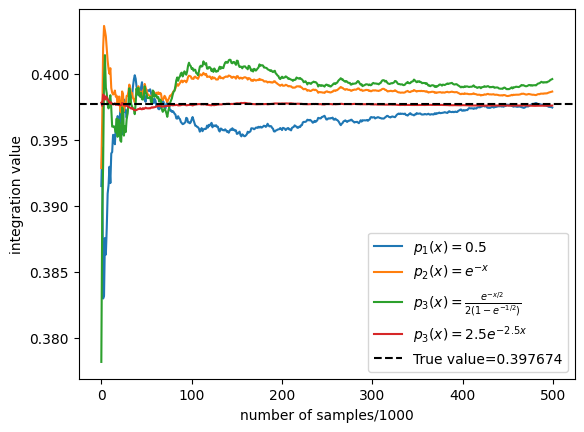

In [20]:
plt.plot(results1, label="$p_1(x)=0.5$")
plt.plot(results2, label="$p_2(x)=e^{-x}$")
plt.plot(results3, label="$p_3(x)=\\frac{e^{-x/2}}{2(1-e^{-1/2})}$")
plt.plot(results4, label="$p_3(x)=2.5e^{-2.5x}$")
true = 0.397674
plt.axhline(y=true, color="k", linestyle="--", label=f"True value={true}")
plt.xlabel(f"number of samples/{N}")
plt.ylabel("integration value")
plt.legend()

In [21]:
print(f"variance with p1(x): {round(np.var(results1)*1e7, 2):>5} * 10^-7")
print(f"variance with p2(x): {round(np.var(results2)*1e7, 2):>5} * 10^-7")
print(f"variance with p3(x): {round(np.var(results3)*1e7, 2):>5} * 10^-7")
print(f"variance with p4(x): {round(np.var(results4)*1e7, 2):>5} * 10^-7")

variance with p1(x): 21.86 * 10^-7
variance with p2(x):  5.01 * 10^-7
variance with p3(x): 21.05 * 10^-7
variance with p4(x):  0.13 * 10^-7


Here we can see that the uniform function ($p_1$) has the most variance. The function $p_2$ resembles the integration function more than $p_1$ hence it has a muc less variance. Then again $p_3$ modves way from the integration function; hence it's variance is again higher. Finally the custom funtion $p_4$ (chosen by me) almost resembles the integration function. hence it's variance is the least.